In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import GridSearchCV
import catboost as catb
import lightgbm as lgb

# Define constants

In [2]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Define helpful functions

In [3]:
def calc_pot_temp(T, p):
    p_0 = 1000.0
    c_p = 1005.0
    R = 287.0

    pot_temp = (T+273.15)*(p_0/p)**(R/c_p)
    return pot_temp

# Read merged meterological & foehn data

In [149]:
df_ERA = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/ERAI_and_North_Foehn_Piotta_data.csv.gz", parse_dates=["date"])
# df_ERA["date"] = pd.to_datetime(df_ERA["date"], format="%Y-%m-%dT%H:%M:00.000Z") # Only if reading from Dataiku file
df_ERA.dropna(inplace=True)
df_ERA.reset_index(inplace=True, drop=True)

# Use only features which are also in CESM and which are not in the Alps

In [150]:
# Only allow features which also exist in CESM
CESMp_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz", nrows=2).columns)
CESMf_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz", nrows=2).columns)
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
intersecting_features.append("Foehn")
df_ERA =df_ERA[intersecting_features]

In [151]:
# Cut Alps as an rectangle and drop those features
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)

intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)

df_ERA.drop(intersecting_features, axis=1, inplace=True)

In [152]:
df_ERA

,Z_4287_1375_500,Z_4759_375_700,U_4947_625_850,V_4287_125_700,T_4853_625_900,T_4853_1375_850,T_4853_375_850,SLP_4476_125_sealevel,T_4759_125_900,Z_4287_0_850,...,Z_4570_375_700,V_4382_375_500,U_4853_0_700,Z_4947_1000_500,T_4947_625_500,SLP_4853_1500_sealevel,U_4853_500_850,Z_4853_875_700,V_4947_125_700,Foehn
0,5638.615723,3125.395508,5.038636,-1.782449,2.707189,-0.495331,2.967222,1034.373535,3.156976,1588.189209,...,3127.624756,-2.892570,6.283257,5646.812500,-23.941322,1032.112305,2.424834,3118.297852,1.965186,0.0
1,5628.941895,3106.197021,6.102051,-2.843265,2.087259,-0.102167,2.948783,1033.199341,4.011744,1576.590698,...,3112.164062,-2.759339,7.612167,5624.413086,-24.420849,1031.231567,4.106144,3100.763916,2.314133,0.0
2,5624.217285,3097.910400,7.555619,-2.917105,1.242475,-0.139079,3.009609,1033.518799,4.154247,1582.286133,...,3108.734131,-3.672627,11.685648,5615.213379,-23.259468,1028.430298,5.460455,3087.218262,3.068814,0.0
3,5618.328613,3097.149414,10.185452,-4.091867,2.699145,0.306836,3.478437,1033.402832,2.752322,1581.450562,...,3105.332764,-7.204986,10.505819,5616.551270,-21.372196,1027.598633,7.559348,3082.063232,0.152056,0.0
4,5608.990723,3098.135498,12.146623,-5.883527,0.408355,-0.185125,1.430293,1033.754028,2.516896,1585.853027,...,3108.711914,-13.338899,15.002035,5616.337402,-20.855431,1026.336426,9.696131,3076.523682,0.844704,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52939,5670.476562,3064.433594,4.683568,4.366075,10.016952,6.381946,3.283762,1019.157471,5.375356,1508.802124,...,3081.962158,8.146772,4.981833,5649.569824,-23.185463,1020.940430,5.090000,3087.796143,3.001707,0.0
52940,5663.645020,3070.796631,5.410240,8.818827,9.784391,5.434401,4.316510,1020.249329,7.228274,1508.176636,...,3075.483887,11.121301,6.040495,5630.303711,-22.620857,1020.985657,6.326363,3084.021729,3.049817,0.0
52941,5646.307129,3058.246338,2.054180,4.696366,8.038952,4.387288,5.325329,1018.498291,6.948185,1485.361084,...,3051.269287,5.103023,-1.985634,5608.715332,-24.029537,1021.395569,2.985642,3067.442871,1.136448,0.0
52942,5648.913574,3057.926514,-2.924476,8.428973,8.636998,5.297881,5.185609,1016.965210,6.835731,1484.722900,...,3052.013672,4.566185,-3.650081,5609.597168,-24.064436,1019.575073,-3.627997,3068.525635,1.767676,0.0


# Calculate derived variables

In [153]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

df_pressures = pd.concat([df_pressures, pd.DataFrame(SLP_dict)], axis = 1)

del SLP_dict

In [154]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

df_Z = pd.concat([df_Z, pd.DataFrame(Z_dict)], axis = 1)

del df_Z_level, Z_dict

In [155]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

df_PHIT = pd.concat([df_PHIT, pd.DataFrame(PHIT_dict)], axis = 1)

del df_T, PHIT_dict

In [156]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")
df_stability = pd.DataFrame(stability_dict)

del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this lo

In [157]:
# Wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [158]:
df_ERA_all_features = pd.concat([df_ERA[["date", "Foehn"]], 
                                 df_pressures, 
                                 df_Z, 
                                 df_PHIT, 
                                 df_stability, 
                                 df_wind], 
                                axis = 1)

# Train Model on full data

In [159]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [160]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

In [161]:
def fit_clf_on_all_features(model, df_ERA, feature_names):
    
    # Fit model
    model.fit(df_ERA.loc[train_mask, feature_names], 
              df_ERA.loc[train_mask, "Foehn"])
    
    # Make predictions
    predictions = model.predict_proba(df_ERA.loc[test_mask, feature_names])
    
    # Calculate best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA.loc[test_mask, "Foehn"], predictions[:,1])
    best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
    predictions = (predictions[:,1]>best_threshold).astype(int)
    
    # Plot precision and recall curves
    f = plt.figure(figsize=(12,5))
    f.add_subplot(121)
    sns.lineplot(precisions, recalls)
    f.add_subplot(122)
    sns.lineplot(np.append(thresholds, 1.0), precisions)
    sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print best threshold, precision, recall and confusion matrix
    print(f"Best threshold: {best_threshold}")
    print(f'Precision: {precision_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(f'Recall: {recall_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(confusion_matrix(df_ERA.loc[test_mask, "Foehn"], predictions))
    
    # Show 50 most important features
    df_ERA_feature_importances = pd.DataFrame({"feature_name": feature_names, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True)
    display(df_ERA_feature_importances.head(50))
    
    return df_ERA_feature_importances

0:	learn: 0.6048979	total: 326ms	remaining: 5m 26s
1:	learn: 0.5420900	total: 567ms	remaining: 4m 42s
2:	learn: 0.4951072	total: 790ms	remaining: 4m 22s
3:	learn: 0.4523973	total: 1.07s	remaining: 4m 25s
4:	learn: 0.4222442	total: 1.29s	remaining: 4m 17s
5:	learn: 0.3966844	total: 1.52s	remaining: 4m 11s
6:	learn: 0.3735272	total: 1.73s	remaining: 4m 5s
7:	learn: 0.3590461	total: 1.95s	remaining: 4m 1s
8:	learn: 0.3470612	total: 2.16s	remaining: 3m 58s
9:	learn: 0.3331233	total: 2.37s	remaining: 3m 54s
10:	learn: 0.3208688	total: 2.6s	remaining: 3m 53s
11:	learn: 0.3104460	total: 2.82s	remaining: 3m 52s
12:	learn: 0.3031445	total: 3.05s	remaining: 3m 51s
13:	learn: 0.2970875	total: 3.27s	remaining: 3m 50s
14:	learn: 0.2911192	total: 3.48s	remaining: 3m 48s
15:	learn: 0.2861718	total: 3.69s	remaining: 3m 46s
16:	learn: 0.2819363	total: 3.91s	remaining: 3m 45s
17:	learn: 0.2767918	total: 4.14s	remaining: 3m 45s
18:	learn: 0.2735520	total: 4.35s	remaining: 3m 44s
19:	learn: 0.2706915	tota

159:	learn: 0.1938595	total: 34.4s	remaining: 3m
160:	learn: 0.1935338	total: 34.6s	remaining: 3m
161:	learn: 0.1932521	total: 34.8s	remaining: 3m
162:	learn: 0.1927836	total: 35s	remaining: 2m 59s
163:	learn: 0.1924391	total: 35.2s	remaining: 2m 59s
164:	learn: 0.1921571	total: 35.4s	remaining: 2m 59s
165:	learn: 0.1919770	total: 35.6s	remaining: 2m 59s
166:	learn: 0.1916167	total: 35.8s	remaining: 2m 58s
167:	learn: 0.1912484	total: 36.1s	remaining: 2m 58s
168:	learn: 0.1908039	total: 36.3s	remaining: 2m 58s
169:	learn: 0.1905209	total: 36.5s	remaining: 2m 58s
170:	learn: 0.1902025	total: 36.7s	remaining: 2m 58s
171:	learn: 0.1899033	total: 36.9s	remaining: 2m 57s
172:	learn: 0.1896539	total: 37.1s	remaining: 2m 57s
173:	learn: 0.1894392	total: 37.3s	remaining: 2m 57s
174:	learn: 0.1890785	total: 37.5s	remaining: 2m 56s
175:	learn: 0.1887731	total: 37.7s	remaining: 2m 56s
176:	learn: 0.1885451	total: 37.9s	remaining: 2m 56s
177:	learn: 0.1882340	total: 38.1s	remaining: 2m 56s
178:	le

316:	learn: 0.1592660	total: 1m 6s	remaining: 2m 22s
317:	learn: 0.1590118	total: 1m 6s	remaining: 2m 22s
318:	learn: 0.1588416	total: 1m 6s	remaining: 2m 22s
319:	learn: 0.1586706	total: 1m 6s	remaining: 2m 22s
320:	learn: 0.1585276	total: 1m 7s	remaining: 2m 21s
321:	learn: 0.1584276	total: 1m 7s	remaining: 2m 21s
322:	learn: 0.1582964	total: 1m 7s	remaining: 2m 21s
323:	learn: 0.1580860	total: 1m 7s	remaining: 2m 21s
324:	learn: 0.1578763	total: 1m 7s	remaining: 2m 20s
325:	learn: 0.1576790	total: 1m 8s	remaining: 2m 20s
326:	learn: 0.1576190	total: 1m 8s	remaining: 2m 20s
327:	learn: 0.1573678	total: 1m 8s	remaining: 2m 20s
328:	learn: 0.1571830	total: 1m 8s	remaining: 2m 19s
329:	learn: 0.1570878	total: 1m 8s	remaining: 2m 19s
330:	learn: 0.1569105	total: 1m 8s	remaining: 2m 19s
331:	learn: 0.1568031	total: 1m 9s	remaining: 2m 19s
332:	learn: 0.1566565	total: 1m 9s	remaining: 2m 18s
333:	learn: 0.1565768	total: 1m 9s	remaining: 2m 18s
334:	learn: 0.1563903	total: 1m 9s	remaining: 

470:	learn: 0.1384701	total: 1m 36s	remaining: 1m 48s
471:	learn: 0.1383783	total: 1m 36s	remaining: 1m 48s
472:	learn: 0.1382486	total: 1m 37s	remaining: 1m 48s
473:	learn: 0.1381907	total: 1m 37s	remaining: 1m 48s
474:	learn: 0.1380428	total: 1m 37s	remaining: 1m 47s
475:	learn: 0.1379675	total: 1m 37s	remaining: 1m 47s
476:	learn: 0.1377983	total: 1m 37s	remaining: 1m 47s
477:	learn: 0.1376565	total: 1m 38s	remaining: 1m 47s
478:	learn: 0.1375088	total: 1m 38s	remaining: 1m 47s
479:	learn: 0.1374359	total: 1m 38s	remaining: 1m 46s
480:	learn: 0.1372375	total: 1m 38s	remaining: 1m 46s
481:	learn: 0.1371301	total: 1m 39s	remaining: 1m 46s
482:	learn: 0.1369931	total: 1m 39s	remaining: 1m 46s
483:	learn: 0.1369200	total: 1m 39s	remaining: 1m 45s
484:	learn: 0.1368285	total: 1m 39s	remaining: 1m 45s
485:	learn: 0.1367186	total: 1m 39s	remaining: 1m 45s
486:	learn: 0.1366469	total: 1m 39s	remaining: 1m 45s
487:	learn: 0.1365801	total: 1m 40s	remaining: 1m 45s
488:	learn: 0.1364901	total:

623:	learn: 0.1236798	total: 2m 7s	remaining: 1m 16s
624:	learn: 0.1235662	total: 2m 7s	remaining: 1m 16s
625:	learn: 0.1234496	total: 2m 7s	remaining: 1m 16s
626:	learn: 0.1233232	total: 2m 7s	remaining: 1m 16s
627:	learn: 0.1232764	total: 2m 8s	remaining: 1m 15s
628:	learn: 0.1231773	total: 2m 8s	remaining: 1m 15s
629:	learn: 0.1231048	total: 2m 8s	remaining: 1m 15s
630:	learn: 0.1229997	total: 2m 8s	remaining: 1m 15s
631:	learn: 0.1229398	total: 2m 8s	remaining: 1m 15s
632:	learn: 0.1228725	total: 2m 9s	remaining: 1m 14s
633:	learn: 0.1227970	total: 2m 9s	remaining: 1m 14s
634:	learn: 0.1226698	total: 2m 9s	remaining: 1m 14s
635:	learn: 0.1226025	total: 2m 9s	remaining: 1m 14s
636:	learn: 0.1225080	total: 2m 9s	remaining: 1m 13s
637:	learn: 0.1224182	total: 2m 10s	remaining: 1m 13s
638:	learn: 0.1223422	total: 2m 10s	remaining: 1m 13s
639:	learn: 0.1222046	total: 2m 10s	remaining: 1m 13s
640:	learn: 0.1221398	total: 2m 10s	remaining: 1m 13s
641:	learn: 0.1220275	total: 2m 10s	remain

779:	learn: 0.1111833	total: 2m 38s	remaining: 44.6s
780:	learn: 0.1110900	total: 2m 38s	remaining: 44.4s
781:	learn: 0.1109822	total: 2m 38s	remaining: 44.2s
782:	learn: 0.1109173	total: 2m 38s	remaining: 44s
783:	learn: 0.1108836	total: 2m 38s	remaining: 43.8s
784:	learn: 0.1107577	total: 2m 39s	remaining: 43.6s
785:	learn: 0.1106528	total: 2m 39s	remaining: 43.4s
786:	learn: 0.1106115	total: 2m 39s	remaining: 43.2s
787:	learn: 0.1105507	total: 2m 39s	remaining: 43s
788:	learn: 0.1104810	total: 2m 39s	remaining: 42.8s
789:	learn: 0.1103866	total: 2m 40s	remaining: 42.6s
790:	learn: 0.1103080	total: 2m 40s	remaining: 42.4s
791:	learn: 0.1102707	total: 2m 40s	remaining: 42.1s
792:	learn: 0.1101818	total: 2m 40s	remaining: 42s
793:	learn: 0.1100823	total: 2m 40s	remaining: 41.7s
794:	learn: 0.1099793	total: 2m 41s	remaining: 41.5s
795:	learn: 0.1099399	total: 2m 41s	remaining: 41.3s
796:	learn: 0.1098419	total: 2m 41s	remaining: 41.1s
797:	learn: 0.1098063	total: 2m 41s	remaining: 40.9s

937:	learn: 0.1009800	total: 3m 9s	remaining: 12.5s
938:	learn: 0.1009066	total: 3m 9s	remaining: 12.3s
939:	learn: 0.1008834	total: 3m 9s	remaining: 12.1s
940:	learn: 0.1007947	total: 3m 9s	remaining: 11.9s
941:	learn: 0.1007328	total: 3m 10s	remaining: 11.7s
942:	learn: 0.1006645	total: 3m 10s	remaining: 11.5s
943:	learn: 0.1005501	total: 3m 10s	remaining: 11.3s
944:	learn: 0.1004893	total: 3m 10s	remaining: 11.1s
945:	learn: 0.1004286	total: 3m 10s	remaining: 10.9s
946:	learn: 0.1003925	total: 3m 11s	remaining: 10.7s
947:	learn: 0.1002971	total: 3m 11s	remaining: 10.5s
948:	learn: 0.1002747	total: 3m 11s	remaining: 10.3s
949:	learn: 0.1001862	total: 3m 11s	remaining: 10.1s
950:	learn: 0.1001035	total: 3m 11s	remaining: 9.88s
951:	learn: 0.1000686	total: 3m 11s	remaining: 9.68s
952:	learn: 0.1000296	total: 3m 12s	remaining: 9.48s
953:	learn: 0.1000014	total: 3m 12s	remaining: 9.28s
954:	learn: 0.0999369	total: 3m 12s	remaining: 9.07s
955:	learn: 0.0998631	total: 3m 12s	remaining: 8.8

,feature_name,importance
0,V_4759_1375_850,1.884738
1,diff_Z_4476_1500_850_Z_4664_375_850,1.404446
2,diff_Z_4570_1375_850_Z_4759_375_850,1.238461
3,diff_SLP_4287_500_sealevel_SLP_4382_500_sealevel,1.176957
4,diff_Z_4476_500_850_Z_4476_625_850,1.117683
5,diff_PHIT_4476_500_850_PHIT_4476_625_850,1.018329
6,diff_PHIT_4476_750_850_PHIT_4476_875_850,0.872472
7,diff_Z_4570_1375_850_Z_4664_250_850,0.789903
8,V_4476_875_850,0.752964
9,diff_Z_4664_1375_850_Z_4853_625_850,0.739322


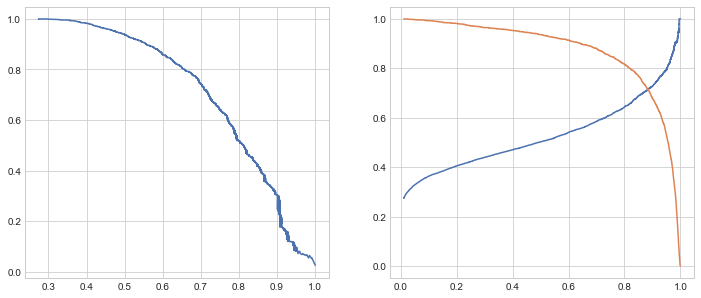

In [162]:
model_cat = catb.CatBoostClassifier(loss_function='Logloss',
                                verbose=True,
                                scale_pos_weight=20,
                                thread_count=20,
                                max_depth=4, 
                                learning_rate=0.1, 
                                n_estimators=1000,
                                reg_lambda=10,
                                   random_state=42)

df_ERA_feature_importances = fit_clf_on_all_features(model_cat, df_ERA_all_features, feature_names)

In [18]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=3,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=100.0,
                    reg_lambda=1.0,
                    n_estimators=100,
                    verbosity=2,
                    nthread=20,
                    scale_pos_weight=20.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )
df_ERA_feature_importances = fit_clf_on_all_features(model_xg)

[15:26:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:14] INFO: /workspace/src/tree/upd

[15:27:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:58] INFO: /workspace/src/tree/upd

XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0.0, max_depth=3,
              min_child_weight=0.0, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=20, nthread=20, num_parallel_tree=1,
              random_state=1337, reg_alpha=100.0, reg_lambda=1.0,
              scale_pos_weight=20.0, seed=1337, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=2)

# Reduce dataframe to most important features

In [208]:
df_ERA_reduced_features = df_ERA_all_features.loc[:,df_ERA_feature_importances.loc[:50, "feature_name"]]
feature_names_reduced = df_ERA_reduced_features.columns.tolist()
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

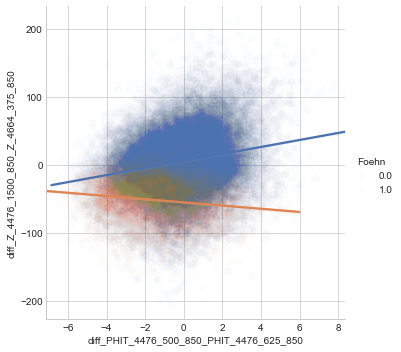

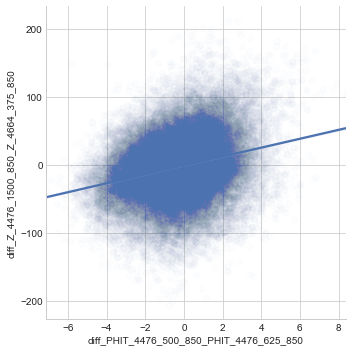

In [373]:
sns.lmplot(x="diff_PHIT_4476_500_850_PHIT_4476_625_850", y="diff_Z_4476_1500_850_Z_4664_375_850", data=df_ERA_reduced_features, hue="Foehn", scatter_kws={"alpha": 0.01})
sns.lmplot(x="diff_PHIT_4476_500_850_PHIT_4476_625_850", y="diff_Z_4476_1500_850_Z_4664_375_850", data=df_ERA_reduced_features, scatter_kws={"alpha": 0.01})

In [209]:
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_ERA.fit(df_ERA_reduced_features.loc[train_mask, feature_names_reduced]) # Only fit on training data

df_ERA_reduced_features_scaled = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_features.loc[:, feature_names_reduced]), 
                                              columns = feature_names_reduced, 
                                              index=df_ERA_reduced_features.index)
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# PCA

[0.48762378 0.13282685 0.0751873  0.05344011 0.03934059 0.03784379
 0.02396503 0.01829789 0.01613884 0.01467512]


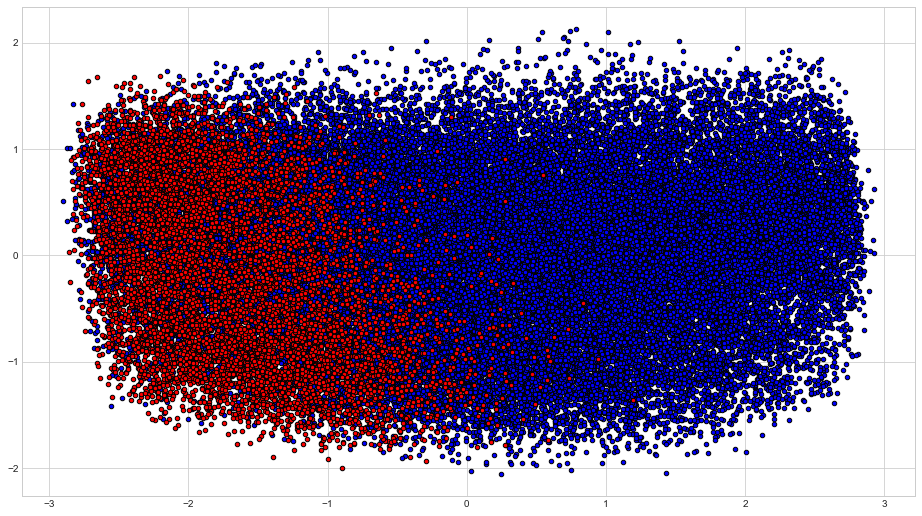

In [210]:
pca = sklearn.decomposition.PCA(n_components=10)
pca.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced])

print(pca.explained_variance_ratio_)

samples_PCA_transformed = pca.transform(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])
#samples_CESMp_PCA_transformed = pca.transform(df_CESMp_reduced_features_scaled.loc[:, feature_names_reduced])

component_1 =0
component_2 =1
plt.figure(figsize=(16,9))

plt.scatter(samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==0, component_1 ], 
            samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==0, component_2 ], 
            c="blue",
            s=20, 
            edgecolor='k')

plt.scatter(samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==1, component_1 ], 
            samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==1, component_2 ], 
            c="red",
            s=20, 
            edgecolor='k')

# plt.figure(figsize=(16,9))

# plt.scatter(samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==0, component_1 ], 
#             samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==0, component_2 ], 
#             c="blue",
#             s=20, 
#             edgecolor='k')

# plt.scatter(samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==1, component_1 ], 
#             samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==1, component_2 ], 
#             c="red",
#             s=20, 
#             edgecolor='k')








Best threshold: 0.41433385152286095
Precision: 0.6717670286278381
Recall: 0.6714356191415886
[[11919   665]
 [  666  1361]]


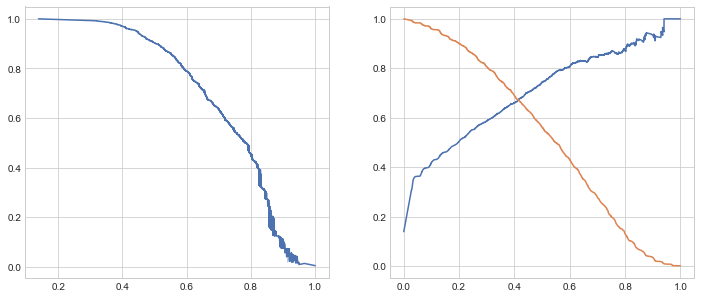

In [211]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=30, n_jobs=25, weights="distance")

model.fit(samples_PCA_transformed[train_mask, :], df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])

predictions = model.predict_proba(samples_PCA_transformed[test_mask, :])

precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions[:,1])
best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
predictions = (predictions[:,1]>best_threshold_ERA).astype(int)

# Plot model evaluation curves
f = plt.figure(figsize=(12,5))
f.add_subplot(121)
sns.lineplot(precisions, recalls)
f.add_subplot(122)
sns.lineplot(np.append(thresholds, 1.0), precisions)
sns.lineplot(np.append(thresholds, 1.0), recalls)

# Print model evaluation scores
print(f"Best threshold: {best_threshold_ERA}")
print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions)}')
print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions)}')
print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions))

# Fit XGBoost to reduced feature set & evaluate

In [374]:
# from sklearn.metrics import log_loss, make_scorer
# def custom_loss(estimator, X, y):
#     log_loss(truth, preds) + 
#     print(truth_logs)
#     np.square(np.mean(estimator.predict_proba(X))-np.mean(y))
#     preds_logs = np.log(preds)
#     numerator = np.sum(np.square(truth_logs - preds_logs))
#     return np.sum(np.sqrt(numerator / len(truth)))

# custom_scorer = make_scorer(custom_loss, greater_is_better=False, needs_proba=True)

SyntaxError: invalid syntax (<ipython-input-374-d7a22eac84e5>, line 3)

In [212]:
def plot_metrics_by_month(precision_scores, recall_scores, f1_scores):
    plt.figure(figsize=(16,9))
    plt.plot(MONTH_NAMES, precision_scores)
    plt.plot(MONTH_NAMES, recall_scores)
    plt.plot(MONTH_NAMES, f1_scores)
    plt.legend(["precision", "recall", "f1-score"])

In [310]:
def get_best_model_through_CV(model, parameters_CV):
    # Fit model
    model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
    model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced], 
                 df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])
    print(model_CV.best_params_)
    
    # Predict and optimize threshold
    best_model = model_CV.best_estimator_
    df_ERA_reduced_features_scaled.loc[:, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
                                                             df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
    df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
    # Plot model evaluation curves
#     f = plt.figure(figsize=(12,5))
#     f.add_subplot(121)
#     sns.lineplot(precisions, recalls)
#     f.add_subplot(122)
#     sns.lineplot(np.append(thresholds, 1.0), precisions)
#     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print model evaluation scores
    
    df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]
    print(f"Best threshold: {best_threshold_ERA}")
    print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]))
    display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
    
    precision_scores, recall_scores, f1_scores = [], [], []
    for month in range(1,12+1):
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)

    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
    return best_model, best_threshold_ERA

In [311]:
def train_model_for_each_month(model, parameters):
    models_retrained_list, thresholds_list = [], []
    
    precision_scores, recall_scores, f1_scores = [], [], []
    
    plt.figure(figsize=(16,9))
    for month in range(1,12+1):
        # Define train and test masks
        train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        all_mask_month =  (df_ERA_reduced_features_scaled["date"].dt.month == month)
        
        # CV
#         model.set_params(scale_pos_weight=df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].count()/df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].sum())
#         print(model.get_params())
        model_CV = GridSearchCV(model, parameters, cv=3, n_jobs=4, scoring='neg_log_loss')
        model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced], 
                     df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"])

        # Get feature importance
#         print(dict(zip(feature_names_reduced, model_CV.best_estimator_.feature_importances_)))
        
        # Optimize threshold
        best_model = model_CV.best_estimator_
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced])[:,1]
        precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                                 df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
        best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
        # Print model evaluation scores
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)
        
        print(f"Best threshold: {best_threshold_ERA}")
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
        display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
        
        # Retrain model on full data
        best_model.fit(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced], 
                       df_ERA_reduced_features_scaled.loc[all_mask_month, "Foehn"])
        models_retrained_list.append(best_model)
        thresholds_list.append(best_threshold_ERA)
        
    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    return models_retrained_list, thresholds_list

Best threshold: 0.6213172674179077
Precision: 0.5196078431372549
Recall: 0.5145631067961165
[[1087   49]
 [  50   53]]


,feature_name,importance
0,diff_PHIT_4570_1375_850_PHIT_4664_1375_850,356
1,diff_PHIT_4664_1375_850_PHIT_4759_1375_850,352
2,DELTAPHI_4382_625_700,321
3,diff_SLP_4382_1250_sealevel_SLP_4382_1375_seal...,305
4,U_4476_500_850,305
5,diff_PHIT_4382_125_850_PHIT_4947_1250_850,303
6,diff_SLP_4287_375_sealevel_SLP_4382_375_sealevel,289
7,U_4853_1000_850,288
8,DELTAPHI_4287_1250_850,279
9,diff_PHIT_4476_750_850_PHIT_4476_875_850,276


Best threshold: 0.6929975152015686
Precision: 0.5654761904761905
Recall: 0.5621301775147929
[[890  73]
 [ 74  95]]


,feature_name,importance
0,diff_SLP_4476_1125_sealevel_SLP_4476_1250_seal...,322
1,DELTAPHI_4853_1000_850,316
2,U_4476_500_850,314
3,diff_SLP_4382_875_sealevel_SLP_4476_1000_sealevel,314
4,diff_PHIT_4664_1375_850_PHIT_4759_1375_850,313
5,diff_PHIT_4570_1375_850_PHIT_4664_1375_850,303
6,DELTAPHI_4382_625_850,298
7,DELTAPHI_4287_1250_850,295
8,diff_PHIT_4476_750_850_PHIT_4476_875_850,286
9,U_4853_1000_850,266


Best threshold: 0.7204663753509521
Precision: 0.72782874617737
Recall: 0.725609756097561
[[823  89]
 [ 90 238]]


,feature_name,importance
0,diff_PHIT_4476_500_850_PHIT_4476_625_850,306
1,diff_PHIT_4570_1375_850_PHIT_4664_1375_850,278
2,diff_SLP_4382_1250_sealevel_SLP_4382_1375_seal...,273
3,DELTAPHI_4853_1000_850,270
4,DELTAPHI_4382_625_700,270
5,DELTAPHI_4382_625_850,266
6,DELTAPHI_4287_1250_850,260
7,DELTAPHI_4476_1000_700,257
8,V_4759_1375_850,257
9,U_4476_500_850,256


Best threshold: 0.6122515201568604
Precision: 0.7821782178217822
Recall: 0.7796052631578947
[[830  66]
 [ 67 237]]


,feature_name,importance
0,DELTAPHI_4287_1250_850,321
1,DELTAPHI_4853_1000_850,305
2,U_4476_500_850,281
3,DELTAPHI_4382_625_850,271
4,diff_SLP_4287_625_sealevel_SLP_4382_500_sealevel,264
5,DELTAPHI_4476_1000_700,253
6,DELTAPHI_4853_875_700,253
7,diff_PHIT_4476_750_850_PHIT_4476_875_850,251
8,V_4759_1375_850,246
9,diff_PHIT_4382_500_850_PHIT_4476_500_850,245


Best threshold: 0.6082609295845032
Precision: 0.7230046948356808
Recall: 0.719626168224299
[[967  59]
 [ 60 154]]


,feature_name,importance
0,DELTAPHI_4287_1250_850,301
1,DELTAPHI_4382_625_850,298
2,diff_PHIT_4476_500_850_PHIT_4476_625_850,296
3,DELTAPHI_4382_625_700,293
4,diff_PHIT_4382_125_850_PHIT_4947_1250_850,290
5,diff_SLP_4382_1250_sealevel_SLP_4382_1375_seal...,272
6,DELTAPHI_4476_1000_700,269
7,diff_SLP_4382_875_sealevel_SLP_4476_1000_sealevel,267
8,diff_SLP_4287_625_sealevel_SLP_4382_500_sealevel,258
9,DELTAPHI_4853_875_700,251


Best threshold: 0.5008963346481323
Precision: 0.6818181818181818
Recall: 0.678391959798995
[[938  63]
 [ 64 135]]


,feature_name,importance
0,DELTAPHI_4853_1000_850,295
1,diff_PHIT_4570_1375_850_PHIT_4664_1375_850,283
2,diff_PHIT_4476_750_850_PHIT_4476_875_850,274
3,DELTAPHI_4382_625_700,269
4,DELTAPHI_4287_1250_850,268
5,V_4759_1375_850,266
6,diff_PHIT_4382_125_850_PHIT_4947_1250_850,263
7,DELTAPHI_4382_625_850,263
8,diff_PHIT_4664_1375_850_PHIT_4759_1375_850,259
9,DELTAPHI_4476_1000_700,258


Best threshold: 0.7169678807258606
Precision: 0.6274509803921569
Recall: 0.6233766233766234
[[1029   57]
 [  58   96]]


,feature_name,importance
0,DELTAPHI_4853_1000_850,313
1,diff_PHIT_4476_750_850_PHIT_4476_875_850,302
2,diff_PHIT_4476_750_850_PHIT_4853_1375_850,267
3,U_4476_500_850,266
4,DELTAPHI_4287_1250_850,266
5,diff_SLP_4476_1125_sealevel_SLP_4476_1250_seal...,262
6,diff_PHIT_4664_1375_850_PHIT_4759_1375_850,261
7,diff_SLP_4287_375_sealevel_SLP_4382_375_sealevel,255
8,diff_SLP_4287_625_sealevel_SLP_4382_500_sealevel,255
9,V_4476_875_850,253


Best threshold: 0.8039659261703491
Precision: 0.66
Recall: 0.6534653465346535
[[1105   34]
 [  35   66]]


,feature_name,importance
0,U_4853_1000_850,408
1,diff_PHIT_4476_500_850_PHIT_4476_625_850,317
2,U_4476_500_850,316
3,diff_PHIT_4382_125_850_PHIT_4947_1250_850,313
4,diff_SLP_4382_875_sealevel_SLP_4476_1000_sealevel,280
5,diff_PHIT_4570_1375_850_PHIT_4664_1375_850,274
6,diff_SLP_4476_1125_sealevel_SLP_4476_1250_seal...,270
7,V_4476_1000_850,259
8,diff_SLP_4287_500_sealevel_SLP_4476_1000_sealevel,255
9,DELTAPHI_4853_1000_850,250


Best threshold: 0.2545526623725891
Precision: 0.6732673267326733
Recall: 0.6666666666666666
[[1065   33]
 [  34   68]]


,feature_name,importance
0,V_4476_1000_850,383
1,diff_PHIT_4476_500_850_PHIT_4476_625_850,373
2,DELTAPHI_4853_1000_700,368
3,DELTAPHI_4853_1000_850,363
4,diff_SLP_4476_1125_sealevel_SLP_4476_1250_seal...,314
5,diff_SLP_4382_875_sealevel_SLP_4476_1000_sealevel,294
6,DELTAPHI_4382_625_850,290
7,diff_PHIT_4570_1375_850_PHIT_4664_1375_850,290
8,U_4476_500_850,278
9,diff_PHIT_4382_500_850_PHIT_4476_500_850,277


Best threshold: 0.6824679374694824
Precision: 0.6410256410256411
Recall: 0.6329113924050633
[[1133   28]
 [  29   50]]


,feature_name,importance
0,DELTAPHI_4382_625_700,440
1,U_4853_1000_850,383
2,diff_PHIT_4476_500_850_PHIT_4476_625_850,328
3,DELTAPHI_4287_1250_850,324
4,diff_PHIT_4476_750_850_PHIT_4476_875_850,309
5,diff_SLP_4476_1125_sealevel_SLP_4476_1250_seal...,292
6,DELTAPHI_4476_1000_700,290
7,DELTAPHI_4853_1000_850,290
8,diff_PHIT_4382_500_850_PHIT_4476_500_850,282
9,DELTAPHI_4382_625_850,268


Best threshold: 0.5224035382270813
Precision: 0.5857142857142857
Recall: 0.5815602836879432
[[1001   58]
 [  59   82]]


,feature_name,importance
0,DELTAPHI_4853_1000_850,364
1,diff_PHIT_4570_1375_850_PHIT_4664_1375_850,308
2,diff_PHIT_4382_125_850_PHIT_4947_1250_850,306
3,diff_SLP_4287_500_sealevel_SLP_4476_1000_sealevel,300
4,V_4476_875_850,294
5,DELTAPHI_4853_1000_700,275
6,DELTAPHI_4287_1250_850,269
7,diff_PHIT_4476_750_850_PHIT_4476_875_850,267
8,DELTAPHI_4476_1000_700,264
9,U_4853_1000_850,253


Best threshold: 0.5303691625595093
Precision: 0.5833333333333334
Recall: 0.5789473684210527
[[1052   55]
 [  56   77]]


,feature_name,importance
0,diff_PHIT_4382_125_850_PHIT_4947_1250_850,335
1,diff_PHIT_4664_1375_850_PHIT_4759_1375_850,303
2,DELTAPHI_4853_1000_850,299
3,U_4853_1000_850,296
4,diff_SLP_4287_625_sealevel_SLP_4382_625_sealevel,292
5,U_4476_500_850,289
6,diff_PHIT_4476_750_850_PHIT_4476_875_850,287
7,diff_SLP_4476_1125_sealevel_SLP_4476_1250_seal...,276
8,diff_PHIT_4570_1375_850_PHIT_4664_1375_850,271
9,DELTAPHI_4382_625_850,268


<Figure size 1152x648 with 0 Axes>

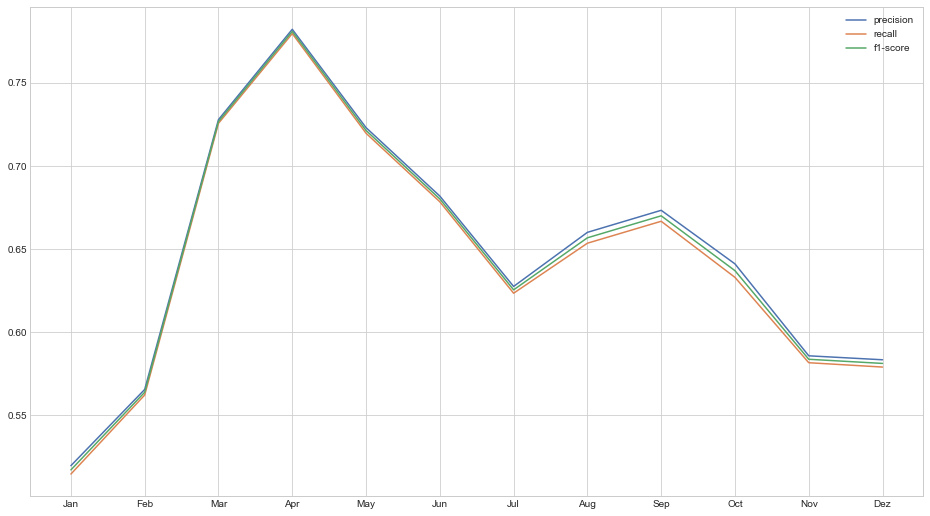

In [344]:
monthly_models = 1
estimator = "LGB" # XGB, CATB, LGB, or KNN

## XGBoost estimator
if estimator == "XGB":
    model = xgb.XGBClassifier(
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    verbosity=0,
                    nthread=5,
                    scale_pos_weight=20.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )


    parameters = {'max_depth': [4], 'learning_rate': [0.1], 'n_estimators':[1000], "reg_alpha":[10], "reg_lambda":[10] }

## CatBoost estimator
elif estimator == "CGB":
    model = catb.CatBoostClassifier(loss_function='Logloss',
                                    verbose=False,
                                    scale_pos_weight=20,
                                    thread_count=5,
                                    random_seed=42)

    parameters = {'max_depth': [4], 'learning_rate': [0.1], 'n_estimators':[1000]}

## LightGBM estimator
elif estimator == "LGB":
    model = lgb.LGBMClassifier(loss_function='Logloss',
                               boosting_type="goss",
                                    verbose=0,
                                    scale_pos_weight=20,
                                    n_jobs=5,
                                    random_seed=42)

    parameters = {'max_depth': [4], 'learning_rate': [0.1], 'n_estimators':[1000]}

## KNN estimator
elif estimator == "KNN": 
    model = sklearn.neighbors.KNeighborsClassifier(n_jobs=8,weights="distance")
    parameters = {'n_neighbors': [30,50]}
elif estimator=="LR":
    model = sklearn.linear_model.LogisticRegression(random_state=42,class_weight={0:1, 1:20}, max_iter=500, n_jobs=30, penalty="l1", solver="saga")
    parameters= {"C":[0.1]}

# Monthly or yearly model
if monthly_models:
    models_retrained_list, thresholds_list = train_model_for_each_month(model, parameters)
else:
    model, best_threshold_ERA = get_best_model_through_CV(model, parameters)
#     model.set_params(n_jobs=25)
    
df_ERA_reduced_features_scaled["dataset"] = "ERA"
df_ERA_reduced_features_scaled["ensemble"] = "ERA"


# Load CESM data 

In [39]:
df_CESMp = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz")
df_CESMp["date"] = pd.to_datetime(df_CESMp["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [40]:
df_CESMf = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz")
df_CESMf["date"] = pd.to_datetime(df_CESMf["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [41]:
# Create pot. temp features for CESMp
df_T= df_CESMp.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMp.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMp.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMp = pd.concat([df_CESMp, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Create pot. temp features for CESMf
df_T= df_CESMf.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMf.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMf.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMf = pd.concat([df_CESMf, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

In [313]:
# Create features which are used by the simplified model
feature_dict_CESMp = {}
feature_dict_CESMf = {}
for feature_name in feature_names_reduced:
    if feature_name[0:6] == "diff_S":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_Z":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_P":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "DELTAP":
        feature_name_splitted = feature_name.split("_")
        first_feature = "PHIT_" + "_".join(feature_name_splitted[1:4])
        second_feature = "PHIT_" + "_".join(feature_name_splitted[1:3]) + "_900"
        
        feature_dict_CESMp["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values
    
    else:
        feature_dict_CESMp[feature_name] = df_CESMp.loc[:, feature_name].values
        feature_dict_CESMf[feature_name] = df_CESMf.loc[:, feature_name].values

feature_dict_CESMp["date"] =df_CESMp.loc[:, "date"].values
feature_dict_CESMf["date"] =df_CESMf.loc[:, "date"].values

feature_dict_CESMp["ensemble"] =df_CESMp.loc[:, "ensemble"].values
feature_dict_CESMf["ensemble"] =df_CESMf.loc[:, "ensemble"].values

df_CESMp_reduced_features = pd.DataFrame(feature_dict_CESMp)
df_CESMf_reduced_features = pd.DataFrame(feature_dict_CESMf)

# Transform features to quantiles on CESM

In [314]:
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced])

df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMp_reduced_features.loc[:, feature_names_reduced].index)

df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMf_reduced_features.loc[:, feature_names_reduced].index)

df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]

df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Predict on CESMp and CESMf

In [345]:
if monthly_models:
    for month in range(1,12+1):
        month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month )
        month_mask_CESMf = (df_CESMf_reduced_features_scaled["date"].dt.month == month )
        
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"] = models_retrained_list[month-1].predict_proba(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced])[:,1]
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction"] = (df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"]> thresholds_list[month-1]).astype(int)

        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"] = models_retrained_list[month-1].predict_proba(df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, feature_names_reduced])[:,1]
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction"] = (df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"]> thresholds_list[month-1]).astype(int)
                                                 
else:
    df_CESMp_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMp_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    df_CESMp_reduced_features_scaled["prediction"] = (df_CESMp_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)
    df_CESMf_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMf_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    df_CESMf_reduced_features_scaled["prediction"] = (df_CESMf_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)

df_CESMp_reduced_features_scaled["dataset"] = "CESMp"
df_CESMf_reduced_features_scaled["dataset"] = "CESMf"

# Playing with relabeling CESMp

In [409]:
# new_labels_CESMp = pd.Series(np.NaN, index=df_CESMp_reduced_features_scaled.index)
# new_labels_CESMp = new_labels_CESMp.mask(df_CESMp_reduced_features_scaled["prediction_proba"]>0.95, 1)
# new_labels_CESMp = new_labels_CESMp.mask(df_CESMp_reduced_features_scaled["prediction_proba"]<0.05, 0)
# new_labels_CESMp.value_counts(dropna=False)

0.0    426339
NaN     60839
1.0     23822
dtype: int64

In [410]:
# def get_best_model_through_CV(model, parameters_CV, df, feature_names, target_variable="Foehn"):
#     # Define train and test masks
#     year_split = 1999
#     train_mask = (df["date"].dt.year < year_split) & (df[target_variable].notnull())
#     test_mask = (df["date"].dt.year >= year_split) & (df[target_variable].notnull())
    
#     # Fit model
#     model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
#     model_CV.fit(df.loc[train_mask, feature_names], 
#                  df.loc[train_mask, target_variable])
#     print(model_CV.best_params_)
    
#     # Predict and optimize threshold
#     best_model = model_CV.best_estimator_
#     df.loc[:, "prediction_proba"] = best_model.predict_proba(df.loc[:, feature_names])[:,1]
#     precisions, recalls, thresholds = precision_recall_curve(df.loc[test_mask, target_variable], 
#                                                              df.loc[test_mask, "prediction_proba"])
#     best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
#     df.loc[:, "prediction"] = (df.loc[:, "prediction_proba"]> best_threshold).astype(int)
    
#     # Plot model evaluation curves
#     f = plt.figure(figsize=(12,5))
#     f.add_subplot(121)
#     sns.lineplot(precisions, recalls)
#     f.add_subplot(122)
#     sns.lineplot(np.append(thresholds, 1.0), precisions)
#     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
#     # Print model evaluation scores
    
#     df.loc[test_mask, "prediction"]
#     print(f"Best threshold: {best_threshold}")
#     print(f'Precision: {precision_score(df.loc[test_mask, target_variable], df.loc[test_mask, "prediction"])}')
#     print(f'Recall: {recall_score(df.loc[test_mask, target_variable], df.loc[test_mask, "prediction"])}')
#     print(confusion_matrix(df.loc[test_mask, target_variable], df.loc[test_mask, "prediction"]))
#     display(pd.DataFrame({"feature_name": feature_names, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
    
#     precision_scores, recall_scores, f1_scores = [], [], []
#     for month in range(1,12+1):
#         test_mask_month =  test_mask & (df["date"].dt.month == month)
#         precision = precision_score(df.loc[test_mask_month, target_variable], df.loc[test_mask_month, "prediction"])
#         recall = recall_score(df.loc[test_mask_month, target_variable], df.loc[test_mask_month, "prediction"])
#         f1score = f1_score(df.loc[test_mask_month, target_variable], df.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)

#     plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
#     return best_model, best_threshold, df

In [411]:
# df_CESMp_reduced_features["Foehn_CESMp"] = new_labels_CESMp

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 10}
Best threshold: 0.91713947057724
Precision: 0.8257607336390163
Recall: 0.8255886643050635
[[84377   836]
 [  837  3962]]


,feature_name,importance
0,diff_Z_4664_1375_850_Z_4853_750_850,0.422572
1,diff_Z_4476_1500_850_Z_4759_375_850,0.187052
2,diff_Z_4570_1375_850_Z_4759_375_850,0.077091
3,diff_Z_4476_750_850_Z_4664_375_850,0.029702
4,diff_PHIT_4476_750_850_PHIT_4853_1125_850,0.027980
5,diff_Z_4476_1000_850_Z_4853_750_850,0.022193
6,DELTAPHI_4382_625_850,0.017633
7,diff_SLP_4287_500_sealevel_SLP_4382_500_sealevel,0.017452
8,DELTAPHI_4853_1000_850,0.016263
9,diff_Z_4382_1375_850_Z_4664_375_850,0.016030


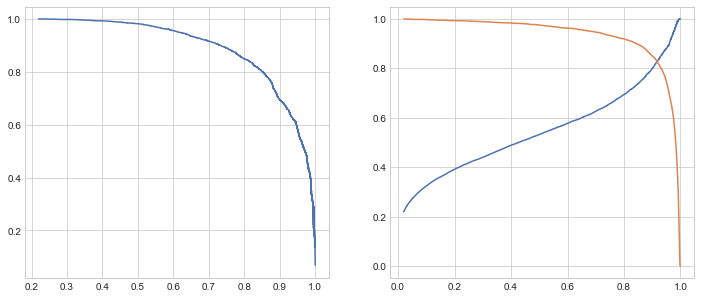

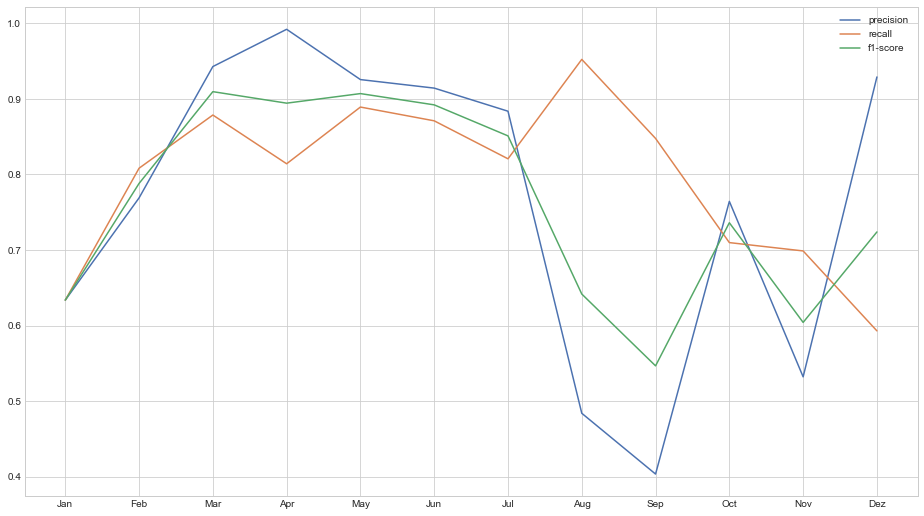

In [412]:
# model_CESMp = xgb.XGBClassifier(
#                     gamma=0.0,
#                     min_child_weight=0.0,
#                     max_delta_step=0.0,
#                     subsample=1.0,
#                     colsample_bytree=1.0,
#                     colsample_bylevel=1.0,
#                     verbosity=0,
#                     nthread=10,
#                     scale_pos_weight=20.0,
#                     base_score=0.2,
#                     seed=1337,
#                     missing=None,
#                   )

# parameters_CESMp = {'max_depth': [4], 'learning_rate': [0.1], 'n_estimators':[100], "reg_alpha":[10], "reg_lambda":[10] }
# best_model_CESMp, best_threshold_CESMp, df_CESMp_reduced_features= get_best_model_through_CV(model= model_CESMp, 
#                                                                   parameters_CV= parameters_CESMp, 
#                                                                   df = df_CESMp_reduced_features, 
#                                                                   feature_names = feature_names_reduced, 
#                                                                   target_variable="Foehn_CESMp")

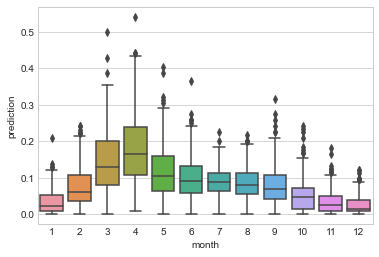

In [413]:
# df_CESMp_reduced_features["month"] = df_CESMp_reduced_features["date"].dt.month
# df_CESMp_reduced_features["year"] = df_CESMp_reduced_features["date"].dt.year
# df_monthly_mean_CESMp = df_CESMp_reduced_features[["date", "year", "month", "ensemble", "prediction"]].groupby(["ensemble", "year", "month"], axis=0, as_index=False).mean()

# fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_CESMp)

# Concenate all dataframes

In [346]:
# Create dataframe for actually observed foehn cases 
df_foehn = df_ERA_reduced_features_scaled.loc[:, ["date", "Foehn"]]
df_foehn["dataset"] = "observed_foehn"
df_foehn["ensemble"] = "observed_foehn"
df_foehn.rename({"Foehn": "prediction"}, axis=1, inplace=True)

In [347]:
# Concat all observed foehn, ERAI, CESMp and CESMf prediction
df_foehn_ERA_CESMp_CESMf = pd.concat([df_foehn, 
                                      df_ERA_reduced_features_scaled, 
                                      df_CESMp_reduced_features_scaled, 
                                      df_CESMf_reduced_features_scaled], 
                                     axis=0, 
                                     ignore_index=True)

In [348]:
# Might be necessary to transform type of date column (should not)
# df_foehn_ERA_CESMp_CESMf["date"] = pd.to_datetime(df_foehn_ERA_CESMp_CESMf["date"], utc=True)

In [349]:
# Create month and year column
df_foehn_ERA_CESMp_CESMf["month"] = df_foehn_ERA_CESMp_CESMf["date"].dt.month
df_foehn_ERA_CESMp_CESMf["year"] = df_foehn_ERA_CESMp_CESMf["date"].dt.year

In [350]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [351]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
test_mask_final_plot = ((1990< df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090< df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

# Create Plots

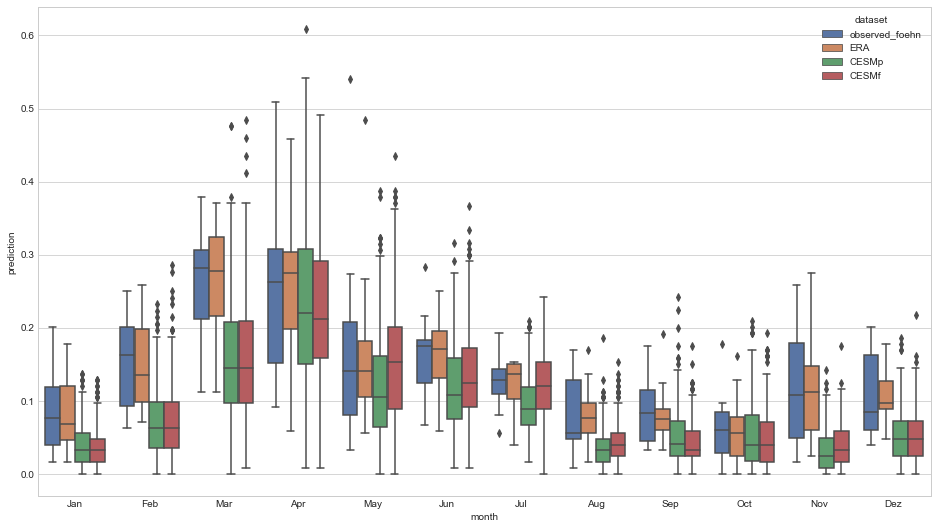

In [352]:
# Plot boxplot for mean foehn frequencies for all datasets
plt.figure(figsize=(16,9))
fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])
fig.set_xticklabels(MONTH_NAMES);

# Second statistical test

(0.0, 0.3)

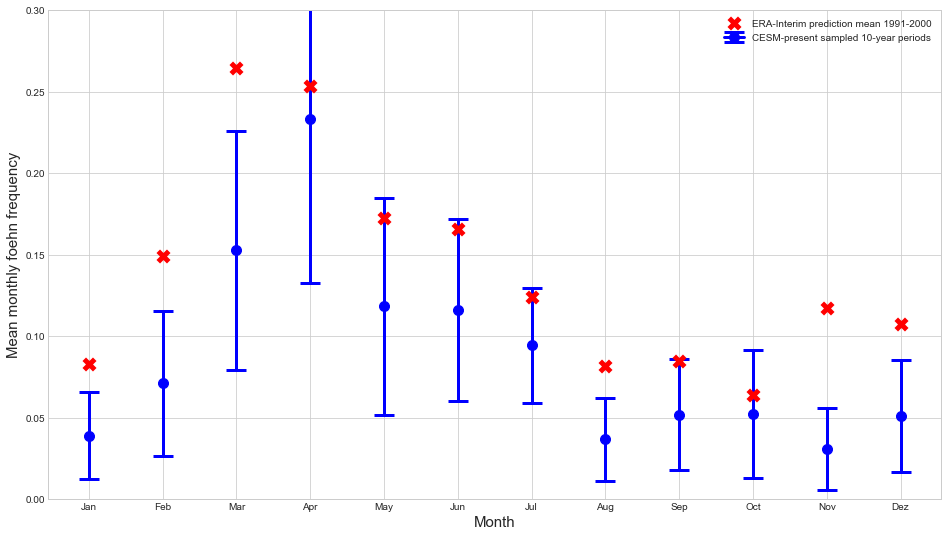

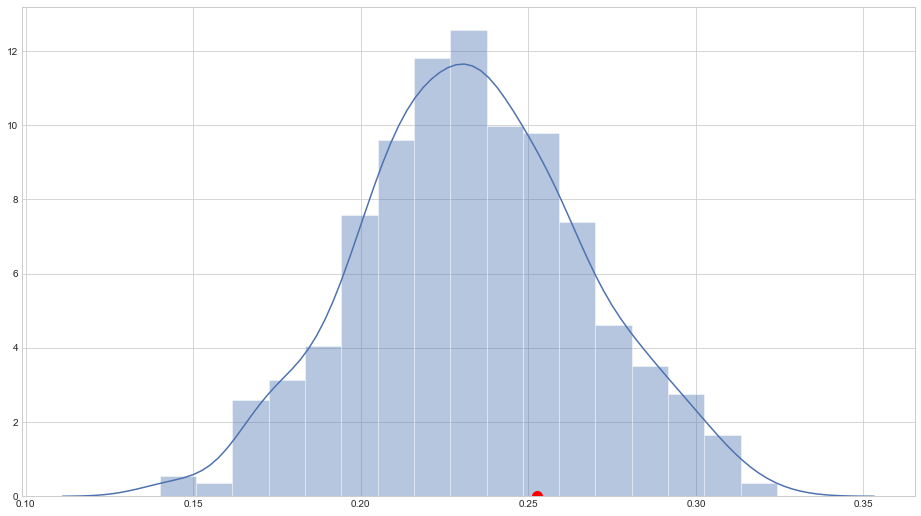

In [353]:
plt.figure(figsize=(16,9))
ax = plt.axes()

for month_test in range(1, 12+1):
    plt.figure(1)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(500):
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
#     if month_test == 2:
#         plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
#                      yerr = np.array([[2.34*np.array(CESM_test_distribution).std(),3*np.array(CESM_test_distribution).std()]]).T, 
#                      color="b", 
#                      marker="o",
#                      markersize=10, 
#                      linewidth=3, 
#                      capsize=10, 
#                      capthick=3, 
#                      zorder=1)
#         plt.scatter(month_test, (df_sum.loc[(df_sum["original_dataset"]=="ERA") & (df_sum["month"]==month_test), "prediction"]).mean(), 
#                     marker="x", 
#                     color="r", 
#                     s=110, 
#                     linewidth=5, 
#                     zorder=10)
#     else:
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 3*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="observed_foehn") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)

    if month_test==4:
        plt.figure(figsize=(16,9))
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
    
    if month_test==1: # To make plot prettier
        legend = ax.legend(["ERA-Interim prediction mean 1991-2000", "CESM-present sampled 10-year periods"])
        
ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("Month",fontsize=15)
ax.set_ylabel("Mean monthly foehn frequency",fontsize=15)
ax.set_ylim((0,0.30))


# Third statistical test

In [354]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])

    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.01))

Jan	0.04924	False
Feb	0.85866	False
Mar	0.74445	False
Apr	0.4944	False
May	0.0	True
Jun	0.00359	True
Jul	0.0	True
Aug	0.18091	False
Sep	0.00609	True
Oct	0.55504	False
Nov	0.10725	False
Dez	0.4944	False


# Ensemble deviation

Text(0, 0.5, 'Mean monthly foehn prediction')

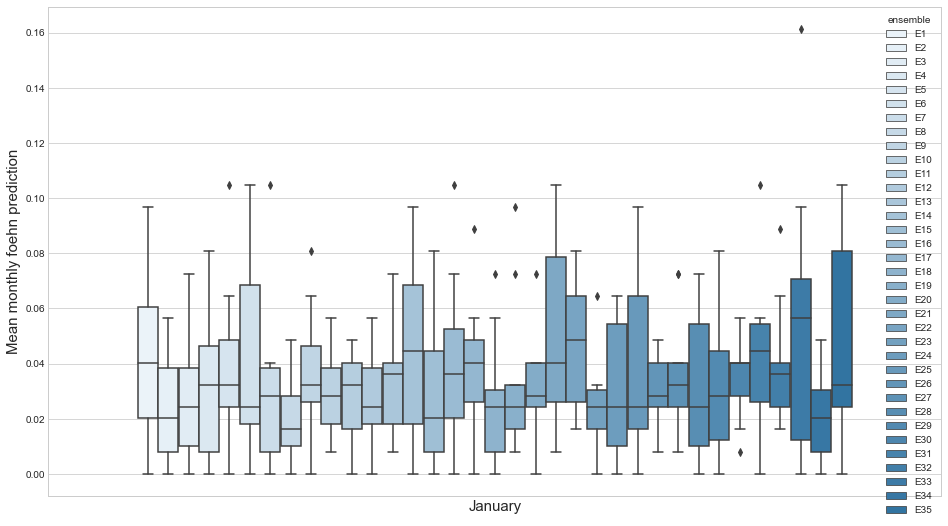

In [239]:
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")

ax.set(xticks=[])
ax.set_xlabel("January",fontsize=15)
ax.set_ylabel("Mean monthly foehn prediction",fontsize=15)
# sns.set(font_scale=0.8)